In [74]:
import os
import sys
import random
import numpy as np
from IPython.display import clear_output
from matplotlib.pyplot import imshow, figure, show, subplots, savefig

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet import preprocess_input

In [2]:
model = load_model("./saved_model/mushie_mobilenet_finetuned.h5")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

---
### TF-Explain comparison tool
[TF-Explain](https://tf-explain.readthedocs.io/en/latest/) is a Python library that combines several XAI methods under a unified API. The methods we'll be comparing here are:
* [GradCAM](https://github.com/sicara/tf-explain#grad-cam): Visualize how parts of the image affects neural network's output by looking into the activation maps.
* [Integrated Gradients](https://github.com/sicara/tf-explain#integrated-gradients): Visualize an average of the gradients along the construction of the input towards the decision.
* [Occlusion Sensitivity](https://github.com/sicara/tf-explain#occlusion-sensitivity): Visualize how parts of the image affects neural network's confidence by occluding parts iteratively
* [SmoothGrad](https://github.com/sicara/tf-explain#smoothgrad): Visualize stabilized gradients on the inputs towards the decision

In [8]:
# Get all the explainer objects into a list so we can loop over them
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.integrated_gradients import IntegratedGradients
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.smoothgrad import SmoothGrad

explainer_list = []
explainer_list.append((GradCAM(), "GradCAM"))
explainer_list.append((IntegratedGradients(), "Integrated Gradients"))
explainer_list.append((OcclusionSensitivity(), "Occlusion Sensitivity"))
explainer_list.append((SmoothGrad(), "SmoothGrad"))

### Image Data
First, choose an image to run through the XAI system. Then, the cells below will use each XAI method below to highlight explanatory features.

In [3]:
path = "../../Google Drive/My Drive/498/Project/mushie_image_data/"

Gyromitrainfula6_gimages.jpg


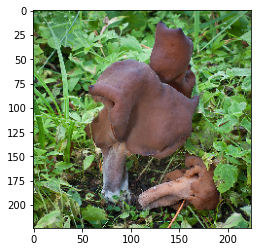

In [207]:
# Choose a random photo from the poisonous folder
mushie_class = "poisonous"
files = os.listdir(path + mushie_class)
d = random.choice(files)
file_path = path + mushie_class + "/" + d

img = load_img(file_path, target_size=(224, 224))
img = img_to_array(img)
img_data = ([img], None)

imshow(img/255.)
print(d)

Agaricusarvensis64_gimages.jpg


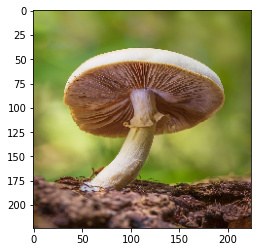

In [187]:
# Or Choose a random photo from the edible folder
mushie_class = "edible"
files = os.listdir(path + mushie_class)
d = random.choice(files)
file_path = path + mushie_class + "/" + d

img = load_img(file_path, target_size=(224, 224))
img = img_to_array(img)
img_data = ([img], None)

imshow(img/255.)
print(d)

In [ ]:
# Make the matplotlib figure, add the original image to it
fig, ax = subplots(1, len(explainer_list)+1, figsize=(25, 5))
fig.suptitle('XAI Methods')
ax[0].imshow(img/255.)
ax[0].title.set_text("Original Image \n{}".format(d))
ax[0].axis('off')

# Then loop through all the explainability methods to compare side-by-side
for i, (explainer, name) in enumerate(explainer_list):
    if name == "Occlusion Sensitivity":
        output = explainer.explain(img_data, model, class_index=0, patch_size=15)
    else:
        output = explainer.explain(img_data, model, class_index=0)
    # add the explanation image to the subplot and save the xai type as a title
    ax[i+1].imshow(output)
    ax[i+1].title.set_text(name)
    ax[i+1].axis('off')
show()


In [189]:
fig.savefig("./ouput_pics/xai_comparison_edible_4.png")

---
### SHAP Comparison Tool
(SHAP)[https://github.com/slundberg/shap] is a Python library that implements SHapley Additive exPlanations. These are a game theoretic approach to explain the output of any machine learning model. They connect optimal credit allocation with local explanations using the classic Shapley values from game theory. See (papers)[https://github.com/slundberg/shap#citations] for details and citations).

We will be experimenting with the GradientExplainer class, which combines ideas from Integrated Gradients (as in TF-Explain), SHAP, and SmoothGrad into a single expected value equation. This allows an entire dataset to be used as the background distribution (as opposed to a single reference value) and allows local smoothing. 